# Lecture 8: Computational Linear Algebra III 

## Data Science Fundamentals

## Linear systems, inversion and matrix decompositions
----
##### DSF - University of Glasgow - Chris McCaig - 2020/2021

## Summary
By the end of this unit you should know:

* the basic anatomy of matrices  how discrete problems can be modelled using continuous mathematics, i.e. using matrices
    * how flows on graphs can be represented as matrix operations
* what eigenvectors and eigenvalues are 
    * how the power iteration method can compute them 
    * how they can be used to decompose matrices
* what the trace and determinant are, and the geometric intuition underlying them
* what positive (semi-)definiteness means and why it is important
* what the singular value decomposition (SVD) is and how it can can be used to compute functions of matrices
* what a linear system of equations is and how it can be represented by a matrix
    * what matrix inversion is and how it relates to solving linear systems of equations
    * the numerical problems with direct inversion
    * what the pseudo-inverse is, how it is derived from the SVD, and how it can be used
* how to normalise data by using matrix operations to "whiten" it
* what a low-rank approximation is and why you might use it


In [ ]:
import IPython.display
IPython.display.HTML("""
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>""")

In [2]:
import numpy as np
import matplotlib as mpl
from jhwutils.matrices import print_matrix, show_matrix_effect
import matplotlib.pyplot as plt
%matplotlib inline

## Edge-weighted graphs

If the some of the connections between distibution centres are stronger than others, e.g. if they are connected by bigger roads, we can model this using edge weights. Now the entry at $A_{ij}$ represents the weight of the connection from vertex $V_i$ to $V_j$.

For example, the graph below has weighted edges:

<img src="imgs/graph_weighted.png">

And the adjacency matrix is:

          A     B     C     D     E     F     G     H
         
     A   0.00  2.00  1.00  0.50  0.00  0.00  0.00  0.00
     B   0.00  0.00  0.00  0.25  3.00  0.00  0.00  0.00
     C   0.00  2.00  0.00  4.00  0.00  0.00  0.00  0.00
     D   0.00  0.00  0.00  0.00  0.00  0.50  2.00  0.50
     E   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
     F   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
     G   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
     H   3.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
     
The easiest way to visualise this matrix is by plotting it as an image:

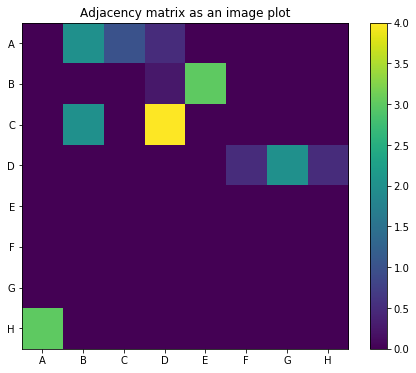

In [8]:
A = [[0.0, 2.0, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.25, 3.0, 0.0, 0.0, 0.0],
    [0.0, 2.0, 0.0, 4.0 , 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0 , 0.0, 0.5, 2.0, 0.5],
    [0.0, 0.0, 0.0, 0.0 , 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0 , 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0 , 0.0, 0.0, 0.0, 0.0],
    [3.0, 0.0, 0.0, 0.0 , 0.0, 0.0, 0.0, 0.0]]

# plot the adjacency matrix A as an image plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1,1,1)
img = ax.imshow(A)
ax.set_xticks(np.arange(8))
ax.set_xticklabels("ABCDEFGH")
ax.set_yticks(np.arange(8))
ax.set_yticklabels("ABCDEFGH")
fig.colorbar(img)
ax.set_title("Adjacency matrix as an image plot");

We can think of graphs as representing flows of "mass" through a network of vertices.

* If the total flow out of a vertex is $>1$, i.e. its row sums to $>1$, then it is a **source** of mass; for example it is *manufacturing* things.
* If the total flow out of a vertex is $<1$, i.e. its row sums to $<1$, then it is a **sink**; for example it is *consuming* things.
* If the total flow out of the vertex is $1$ exactly, i.e. its row sums to $1$ exactly, then it conserves mass; it only ever *re-routes* things.

Can you see which vertices are sources and sinks in the above graph?

If the whole graph consists of vertices whose total outgoing weight is 1.0, and all weights are positive or zero, then the whole graph preserves mass under flow. Nothing is produced or consumed. Every row in the adjacency matrix $A$ sums to 1. This is called a **conserving adjacency matrix**. We can normalise the rows of any positive matrix $A$ (so long as each vertex has at least some flow out of it) to form a conserving adjacency matrix.

---

## Flow analysis: using matrices to model discrete problems

Previously, we have talked about how matrices perform geometrical transformations on vectors. Matrices are sometimes referred to as *linear maps* because they map from one vector to another, using only linear operations. The adjacency matrix does this too.

What does this mean? What vectors does it operate on? What does the geometrical transformation (linear mapping) represent?

At any point in time, we can write down the proportion of packages at each depot as a vector $\vec{x_t} \in \real^{V}$, where $V$ is the number of vertices in the graph (number of depots), e.g.

$$\vec{x_t} = \begin{bmatrix} 0.05 & 0.15 & 0.30 & 0.20 & 0.03 & 0.12 & 0.08 & 0.07 \end{bmatrix}$$

The flow of packages (per day) between depots is a linear map $\real^{V} \rightarrow \real^{V}$. This is represented by the adjacency matrix $A \in \real^{V \times V}$ (a square matrix).

This allows us to analyse an apparently *discrete* problem (connectivity of graphs) with tools from *continuous* mathematics (vectors and matrices).

The switch of viewpoints from discrete to continuous (and vice versa) is a very powerful and fundamental step in data analysis. It might not seem like it, but the flow of packages can be modelled as some rigid rotation and scaling in a high-dimensional space.

We saw the same kind of application in Unit 4, when we transformed the translation problem from a problem of strings (discrete) to a problem in vector spaces (continuous) and made it solvable.

A great many problems can be represented this way:

* packages moving between depots (how many packages at each depot at an instant in time)
* users moving between web pages (how many users on each webpage)
* cancer cells moving between tumour sites (how many cancer cells at each tumour site)
* trade between states (how many items in each state)
* shoppers walking between retailers (how many shoppers in each shop)
* traffic across a load-balancing network (how many cars at each junction)
* NPCs (non-player characters) moving between towns in a game (how many NPCs in each town)
* fluid moving between regions (how much fluid in each tank)
* blood flowing between organs (how much blood in each organ)
* beliefs moving among hypotheses (how much we believe in each hypothesis)

## Simulation of changes in package distribution over time

Suppose we start with an *initial distribution* of packages: a vector $\vec{x_{t=0}}$. How many packages will be at each depot tomorrow? This will be given by the vector $\vec{x_{t=1}}$, which can be computed as follows:

$$\vec{x_{t=1}} = \vec{x_{t=0}} \, A$$

We can simulate the flow *over the whole network* in one go with just one matrix multiplication. This "rotates" the distribution of packages from today to tomorrow. The advantage of vectorised operations is that they can be accelerated using hardware such as a GPU (Graphics Processing Unit).

N.B. Because we are working with row vectors, the adjacency matrix post-multiplies the package-state vector. This is due to the way the adjacency matrix is defined. For other applications we often work with column vectors, in which case the matrix pre-multiplies the vector.
    
-----    
    
## Important questions    
There are some harder questions we can ask:
* What about in a week's time? What will $\vec{x_{t=7}}$ be?
* What about in *one hour's* time (i.e. a 24th of a day)? What will be $\vec{x_{t=1/24}}$ be?
* What about at time infinity $\vec{x_{t=\infty}}$? What is the long term behaviour? Will the system reach a steady state (an **equilibrium**)? Or will it oscillate forever?
* What about if we wanted to go backwards in time? If we know $\vec{x_{t=0}}$, can we predict yesterday $\vec{x_{t=-1}}$?

We will solve these problems today, using some new operations that we can do with *certain kinds* of matrices:

## Some new matrix operations
<div class="alert alert-info">
    For most of this lecture, we will restrict ourselves to talking about square $n\times n$ matrices.
</div>

For square matrices $A$ (i.e. representing **linear transforms**):
* Matrices can be exponentiated: $C = A^n$; this "repeats" the effect of matrix 
* Matrices can be inverted: $C = A^{-1}$; this undoes the effect of a matrix 
* We can find eigenvalues: $A\vec{x} = \lambda \vec{x}$; this identifies specific vectors $\vec{x}$ that are *only* scaled by a factor $\lambda$ (not rotated) when transformed by matrix $A$.
* Matrices can be factorised: $A = U\Sigma V^T$; any matrix can expressed as the product of three other matrices with special forms. 
* We can measure some properties of $A$ numerically, including the **determinant**, **trace** and **condition number**.

---

# Matrix powers (exponentiation)

Since we have already defined matrix multiplication, we can now define $A^2=AA$, $A^3=AAA$, $A^4=AAAA$, etc. These are the **powers** of a matrix, and are only defined for square matrices. Matrix exponentiation is the **repeated application** of a matrix, and it can only be defined for square matrices because we'd otherwise change the dimensions after the first step and be unable to reapply the same matrix.

This answers the question, *"What about in a week's time? What will $\vec{x_{t=7}}$ be?"* We can simply apply the matrix seven times; raising it to the power of 7.

Matrix powers are very easy to compute for positive, whole powers:

In [9]:
# Define a function that raises a matrix A to the power n
def powm(A, n):    
    B = np.eye(A.shape[0]) # start with identity    
    for i in range(n):
        B = A @ B  # @ performs matrix multiplication
    return B

In [10]:
# Demonstrate raising a matrix A to powers from 0 to 5
A = np.array([[1.5, 0.0], [-1.1, 0.1]])
print_matrix("A", A)

for i in range(5):
    print_matrix("A^%d" % i, powm(A, i))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Matrix powers correspond to applying a matrix multiple times, compounding the effect.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

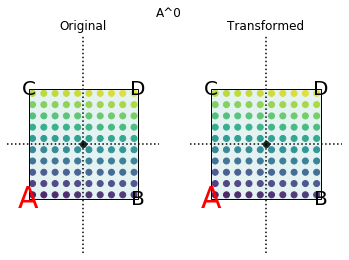

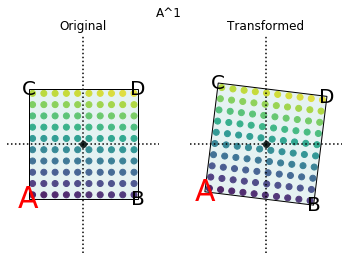

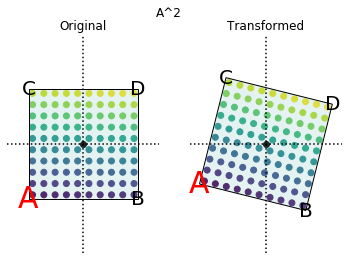

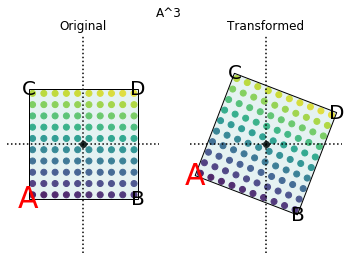

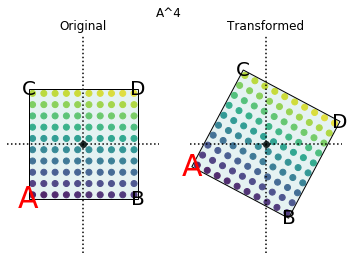

In [11]:
# Demonstrate the effect of applying a 7-degree rotation matrix repeatedly,
# i.e. raising it to powers from 0 to 5

rad = np.radians(7) # converts 7 degrees into radians.
c = np.cos(rad)
s = np.sin(rad)
rot = np.array([[c, s], [-s, c]])
print_matrix("A", rot)

# display plots of original and transformed matrix for several different powers
for i in range(5):
    show_matrix_effect(powm(rot, i), 'A^%d' % i) 

---

# Stable point: all roads lead to Rome

Here is a simple experiment. Imagine we have a conserving adjacency matrix modelling the flow of packages around a network of depots. If we start with different package distributions and then let the "natural" flow begin, what will happen?

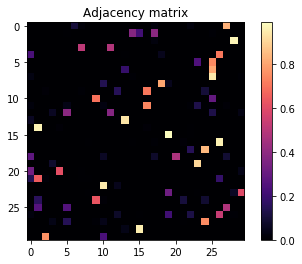

In [12]:
n_nodes = 30

# generate a random transition matrix
adjacency = np.random.uniform(0, 1, (n_nodes, n_nodes))**50

# normalise rows to make a conserving adjacency matrix
adjacency = (adjacency.T / np.sum(adjacency, axis=1)).T

# show the adjacency matrix
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
img = ax.imshow(adjacency, cmap='magma')
ax.set_title("Adjacency matrix")
fig.colorbar(img)

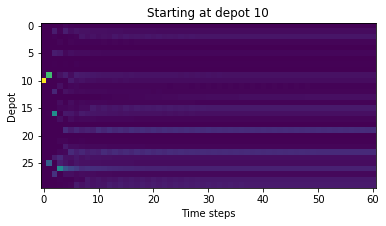

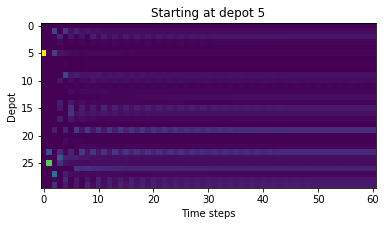

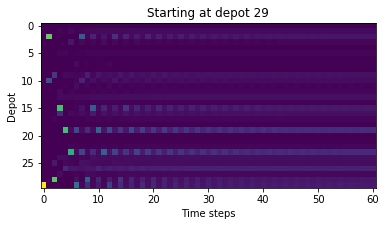

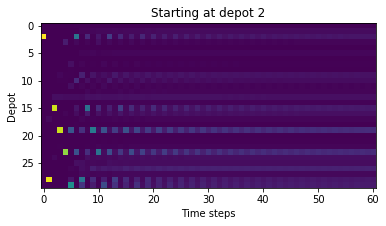

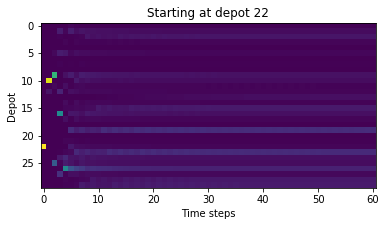

In [13]:
# now we do some experiments where we try starting the system in different states 
# and see how it evolves (we can imagine a system of tanks, where we put dye in 
# one tank to begin with, and see where it ends up after we turn the pump on)
timesteps = 60

# run the experiment a few times with different starting states
for j in range(5):
    test_vector = np.zeros((1, n_nodes))  # initialise a row vector
    
    # choose a random node to start all the packages in
    node = np.random.randint(0, n_nodes)
    test_vector[0][node] = 1

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    # initialise a list to store vectors at every time point
    vectors = []
    vectors.append(test_vector.T) # store as column vector
    
    # let the system evolve over a number of timesteps
    for i in range(timesteps):
        test_vector = test_vector @ adjacency
        vectors.append(test_vector.T)        

    # plot the state vector as a function of time
    all_vectors = np.hstack(vectors)
    ax.imshow(all_vectors)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Depot")
    ax.set_title("Starting at depot %d" % node)

No matter what the initial package distribution is, after several days the distribution will settle down to a **steady state** (or stable point). This vector is one of the *eigenvectors* of the adjacency matrix.

---

# Eigenvalues and eigenvectors

A matrix represents a special kind of function: a **linear transform**; an operation that performs rotation and scaling on vectors. However, there are certain vectors which don't get rotated when multiplied by the matrix. They only get scaled (stretched or compressed). These vectors are called **eigenvectors**, and they can be thought of as the "fundamental" or "characteristic" vectors of the matrix, as they have some stability. The prefix **eigen** just means **characteristic** (from the German for "own"). The scaling factors that the matrix applies to its eigenvectors are called **eigenvalues**.

We can visualise the effect of a matrix transformation by imagining a parallelepiped (whose edges are vectors) being rotated, stretched and compressed. If the edges of the parallelelpiped are the eigenvectors of the matrix, the parallelepiped will only be stretched or compressed, not rotated. If the edges of this parallelepiped have unit length, then after the transformation their lengths will be equal to the eigenvalues. The youtube video series on linear algebra by [3blue1brown](https://www.youtube.com/playlist?list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab) illustrates this particularly well.

<img src="imgs/eigs.png">

When we are dealing with $n$-dimensional matrices, we have to imagine an $n$-dimensional parallelotope being transformed in the same way.

## How to find the leading eigenvector: the power iteration method

Our example, "All roads lead to Rome", illustrates how to find one of the eigenvectors of a matrix. We simply apply the matrix repeatedly to a random initial vector and wait until the result converges to a steady state. However, there is one important caveat ...

What happens if we apply a square matrix $A$ to a vector $\vec{x}$ of any length, then take the resulting vector and apply $A$ again, and so on?

Let's work with column vectors now, so that $A$ pre-multiplies the vector. If we compute

$$\vec{x_n} = AAAA\dots AA\vec{x_0} \\ = A^{n}\vec{x_0}$$

this will generally either explode in value or collapse to zero. However, we can fix the problem by **normalizing** the resulting vector after each application of the matrix:

$$\vec{x_n} = \frac{A \vec{x_{n-1}}}{\|A\vec{x_{n-1}}\|_\infty}$$

The vector will be forced back to unit norm at each step, using the $L_\infty$ norm. This process is called **power iteration**.

N.B. You can use any norm for normalisation. The infinity norm has been used traditionally, probably for reasons of efficiency.

Let's demonstrate power iteration with a random $3 \times 3$ matrix $A$:

In [14]:
def power_iterate(A, x, n):  
    
    for i in range(n):
        
        x = A @ x # matrix multiplication
        x = x / np.linalg.norm(x, np.inf) # normalize x using the L-infinity norm during power iteration
        
    return x / np.linalg.norm(x, 2) # finally, divide by the L2 norm so x can be compared with result of np.linalg.eig

In [15]:
# create a random 3 x 3 matrix
A = np.random.normal(0, 1, (3, 3))

# make it symmetric to ensure all eigenvalues are real (not complex)
A = A + A.T
print_matrix("A", A)

<IPython.core.display.Latex object>

In [23]:
# create a random 3-element column vector
random_vec = np.random.normal(0, 1, (3, 1))
print_matrix("\\bf{x_0}", random_vec)

<IPython.core.display.Latex object>

In [24]:
# do power iteration on this vector for enough iterations 
# to ensure it converges to the leading eigenvector
power = power_iterate(A, random_vec, n=500)
print_matrix("\\bf{x_{n}}", power)

<IPython.core.display.Latex object>

Regardless of which vector $\vec{x_0}$ we start with (the vector above is chosen randomly), the power iteration method always approaches a fixed vector (though possibly with sign flips). This is true for almost every square matrix. 

The vector that results from power iteration is known as the **leading eigenvector**. It satisfies the definition of an eigenvector because the matrix $A$ performs only scaling on this vector (no rotation). We know this **must** be true, because the scaling effect is eliminated by the normalisation step in the power iteration, but any other effects pass through. We can write the scaling effect of the $A$ on an eigenvector $\vec{x}$ as follows:

$$A\vec{x} = \lambda \vec{x}$$

where $\lambda$ is the eigenvalue. We can calculate $\lambda$ simply by dividing the vector $A\vec{x}$ element-wise by the vector $\vec{x}$:

In [25]:
ratio = (A @ power) / power
print_matrix("\\frac{A\\bf x}{\\bf x}", ratio)
eigenvalue = ratio[0][0] # all elements of ratio will be the same
print_matrix("\lambda", eigenvalue)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Computing eigenvectors and eigenvalues with Numpy

The power iteration method enables us to calculate the leading eigenvector and eigenvalue, but if we want to know **all** the eigenvectors and eigenvalues of a matrix, we can use `np.linalg.eig`:

In [26]:
# Compute eigenvalues and eigenvectors with Numpy
evals, evecs = np.linalg.eig(A)  
# evecs is a matrix whose columns are the unit eigenvectors
print("Eigenvalues:\n", evals)
print()
print("Unit Eigenvectors (columns):\n", evecs)

Eigenvalues:
 [-3.93088574  1.80362468 -0.97178857]

Unit Eigenvectors (columns):
 [[ 0.78642711  0.56142308  0.25755877]
 [ 0.16784123 -0.59551647  0.78561407]
 [-0.59444236  0.57459922  0.56256023]]


The leading eigenvector and eigenvalue should match the results we obtained by power iteration.

Notice that our $3 \times 3$ matrix has 3 eigenvalues and 3 eigenvectors. In general, for an $n \times n$ matrix, `np.linalg.eig` will yield $n$ eigenvalues and $n$ eigenvectors. The eigenvectors are **orthogonal**, i.e. the dot product of any pair of eigenvectors is zero.

For very large matrices, if you just want to compute the leading eigenvector, power iteration is much faster than using `np.linalg.eig`.

## Formal definition of eigenvectors and eigenvalues

Now that we have explored the concepts of eigenvectors and eigenvalues through practical examples, we can move on to a formal definition:

Consider a vector function $f(\vec{x})$. There may exist vectors such that $f(\vec{x}) = \lambda\vec{x}$. The function maps these vectors to scaled versions of themselves. No rotation or skewing is applied, just pure scaling.

Any square matrix $A$ represents a function $f(\vec{x})$ and may have vectors like this, such that 

$$
A\vec{x}_i = \lambda_i \vec{x}_i
$$

Each vector $\vec{x}_i$ satisfying this equation is known as an **eigenvector** and each corresponding factor $\lambda_i$ is known as an **eigenvalue**. 

For any matrix, the **eigenvalues** are uniquely determined, but the eigenvectors are not. There may be many eigenvectors corresponding to any given eigenvalue (for example, pairs of vectors that point in opposite directions).

**Eigenproblems** are problems that can be tackled using eigenvalues and eigenvectors.

## The eigendecomposition: revisiting packages

Let's revisit our package distribution example and compute all the eigenvectors and eigenvalues of an adjacency matrix. 

We will work with an *undirected* (symmetric) graph to ensure that the eigenvalues are all real (an adjacency matrix whose eigenvalues are all complex would have no steady state, but instead would converge to an oscillatory state).

N.B. Making the adjacency matrix symmetric also means we don't have to worry about transposing it before using `np.linalg.eig` (the adjacency matrix is defined such that it operates on row vectors, but `np.linalg.eig` returns column eigenvectors).

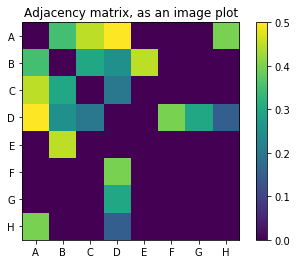

In [27]:
# set up an adjacency matrix A to represent package flow
A = np.array([[0.0, 0.7, 0.9, 1.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.5, 0.9, 0.0, 0.0, 0.0],
              [0.0, 0.6, 0.0, 0.4 , 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0 , 0.0, 0.8, 0.6, 0.3],
              [0.0, 0.0, 0.0, 0.0 , 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0 , 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0 , 0.0, 0.0, 0.0, 0.0],
              [0.8, 0.0, 0.0, 0.0 , 0.0, 0.0, 0.0, 0.0]])

# make A symmetric (undirected)
A = (A + A.T) * 0.5

# plot adjacency matrix as image
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
img = ax.imshow(A)
ax.set_xticks(np.arange(8))
ax.set_xticklabels("ABCDEFGH")
ax.set_yticks(np.arange(8))
ax.set_yticklabels("ABCDEFGH")
fig.colorbar(img)
ax.set_title("Adjacency matrix, as an image plot");

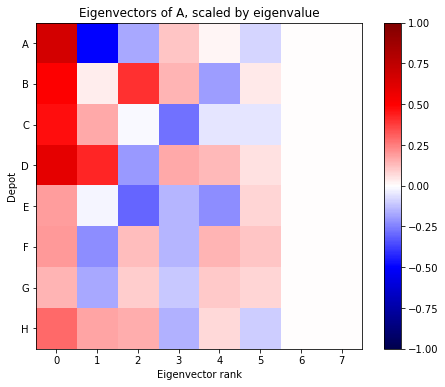

In [28]:
# compute eigendecomposition of A
evals, evecs = np.linalg.eig(A)

# plot eigenvectors as an image, in order of decreasing eigenvalue
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1,1,1)
order = np.argsort(-np.abs(evals))
img = ax.imshow(((evecs[:, order] * evals[order])), cmap='seismic', vmin=-1, vmax=1)
ax.set_yticklabels("ABCDEFGH")
ax.set_yticks(np.arange(8))
ax.set_xlabel("Eigenvector rank")
ax.set_ylabel("Depot")
fig.colorbar(img)#, orientation='horizontal')
ax.set_title("Eigenvectors of A, scaled by eigenvalue");

The leading eigenvector tells us what the steady state of the package distribution will be if we keep the system running for long enough. For this distribution network, most of the packages will pile up at A, B, C, D and H.

From the eigendecomposition we can get a feel for which eigenvectors are large and which are small. In the case of package distribution, small eigenvalues correspond to route patterns that are rarely used, and large eigenvalues to the dominant path of packages moving through the system.

## The eigenspectrum

The **eigenspectrum** is just the sequence of absolute eigenvalues, ordered by magnitude $|\lambda_1|>|\lambda_2|>|>\dots>|\lambda_n|$. This *ranks* the eigenvectors in order of "importance". As we shall see later, this can be useful in finding "simplified" versions of linear transforms.

<IPython.core.display.Latex object>

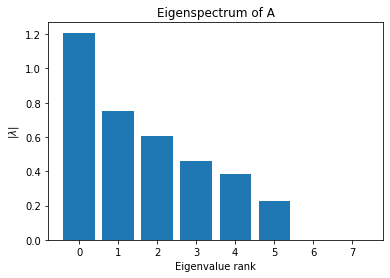

In [29]:
# sort eigenvalues by absolute value 
print_matrix("|\lambda_i|", np.abs(evals[np.argsort(-np.abs(evals))]))

# plot the eigenspectrum (magnitudes of eigenvalues in decreaing order)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.bar(np.arange(len(evals)), np.abs(evals[np.argsort(-np.abs(evals))]))
ax.set_title("Eigenspectrum of A")
ax.set_xlabel("Eigenvalue rank")
ax.set_ylabel("$|\lambda|$");

## Numerical instability of eigendecomposition algorithms

A word of warning: `np.linalg.eig` can suffer from numerical instabilities due to rounding errors resulting from limitations on floating point precision. This means that sometimes the smallest eigenvectors are not completely orthogonal. `np.linalg.eig` is often sufficient for most purposes, but be careful how you use it. 

If your matrix satisfies certain special conditions, you might be able to use a more stable algorithm. For example, if it is real and symmetric (or Hermitian, in the case of a complex matrix), you can use `np.linalg.eigh`. 

We will demonstrate the difference between the two algorithms here, using the real, symmetric adjacency matrix $A$ that we created above:

In [30]:
# compute eigendecomposition of A using np.linalg.eig
evals, evecs = np.linalg.eig(A)

# Get the indices of the eigenvalues in order of largest to smallest (absolute value)
order = np.argsort(-np.abs(evals))

# Reorder eigenvalues and eigenvectors from largest to smallest eigenvalue (absolute value)
evals = evals[order]
evecs = evecs[:, order]

# Display eigenvectors x_i (columns) in order from largest to smallest eigenvalue (absolute)
print("Eigenvectors computed with np.linalg.eig:")
print_matrix("\\bf{x_i}", evecs)

print()

# compute eigendecomposition of A using np.linalg.eigh (we can use this because A is real and symmetric)
evalsh, evecsh = np.linalg.eigh(A)

# Get the indices of the eigenvalues in order of largest to smallest (absolute value)
order = np.argsort(-np.abs(evalsh))

# Reorder eigenvalues and eigenvectors from largest to smallest eigenvalue (absolute value)
evalsh = evalsh[order]
evecsh = evecsh[:, order]

# Display eigenvectors x_i (columns) in order from largest to smallest eigenvalue (absolute)
print("Eigenvectors computed with np.linalg.eigh:")
print_matrix("\\bf{x_i}", evecsh)

Eigenvectors computed with np.linalg.eig:


<IPython.core.display.Latex object>


Eigenvectors computed with np.linalg.eigh:


<IPython.core.display.Latex object>

Notice how the first six eigenvectors are very similar for both algorithms, but the last two are quite different. These correspond to the smallest eigenvalues. Let's compute the dot product of the last two eigenvectors for both algorithms:

In [31]:
print("Dot product of last two eigenvectors obtained with np.linalg.eig:")
print(np.dot(evecs[:,6], evecs[:,7]))

print()

print("Dot product of last two eigenvectors obtained with np.linalg.eigh:")
print(np.dot(evecsh[:,6], evecsh[:,7]))

Dot product of last two eigenvectors obtained with np.linalg.eig:
0.24885950046747043

Dot product of last two eigenvectors obtained with np.linalg.eigh:
4.163336342344337e-17


Notice how rounding errors have caused the last two eigenvectors from `np.linalg.eig` to be non-orthogonal, whereas the more stable `np.linalg.eigh` yields orthogonal eigenvectors with a dot product close to zero. Let's list all the eigenvalues from the two algorithms to see where the problem lies:

In [32]:
print("Eigenvalues from np.linalg.eig:")
for eval in evals:
    print(eval)

print()

print("Eigenvalues from np.linalg.eigh:")
for eval in evalsh:
    print(eval)

Eigenvalues from np.linalg.eig:
1.2081836775165697
-0.7518836099776213
-0.6079838328486065
-0.4590542684532088
0.3862627839370782
0.22447524982578987
-1.7656392397134707e-17
-3.66234478599236e-18

Eigenvalues from np.linalg.eigh:
1.2081836775165669
-0.7518836099776197
-0.6079838328486069
-0.45905426845320885
0.38626278393707836
0.22447524982578965
1.7771052342538512e-17
-6.680674224851918e-18


Differences between the eigenvalues from the two algorithms occur around the 15th or 16th significant figure. Because the smallest eigenvalues are of the order 1e-17, the rounding errors in `np.linalg.eig` become quite significant for these two eigenvalues and their corresponding eigenvectors.

---

---

# Principal Component Analysis (PCA)

We saw the covariance matrix $\Sigma$ in the previous Unit. It tells us how much correlation there is between the variables in a data set. We can plot a representation of the covariance matrix as an ellipse which aligns with the distribution of the data points. Uncorrelated data is represented by a circle, whereas strongly correlated data is represented by a long thin ellipse. The eigenvectors of the covariance matrix, scaled by their eigenvalues, form the principal axes of the ellipse.

## Decomposition of the covariance matrix into its eigenvectors and eigenvalues

The eigenvectors of the covariance matrix are called the **principal components**, and they tell us the directions in which the data varies most. This is an incredibly useful thing to be able to do, particularly with high-dimensional data sets where the variables may be correlated in complicated ways.

The direction of principal component $i$ is given by the eigenvector $\vec{x}_i$, and the length of the component is given by $\sqrt{\lambda_i}$.

We will illustrate this by generating a dataset with 2 correlated variables and 200 data points:

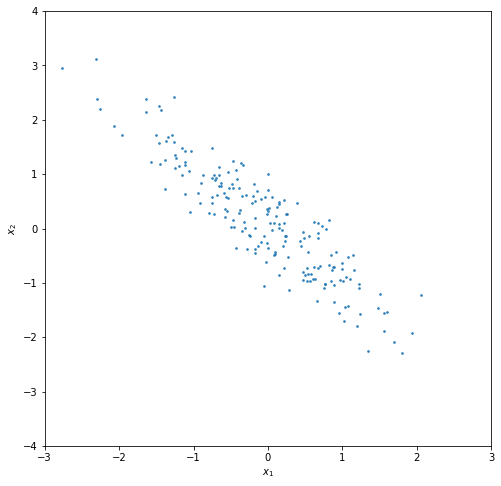

In [3]:
# Construct a matrix x of 200 random data points (x_1, x_2), where x_1 and x_2 are correlated
x = np.random.normal(0, 1, (200, 2)) @ np.array([[0.05, 0.4], [-0.9, 1.0]]) 

# plot the dataset
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x[:, 0], x[:, 1], c='C0', label="Original data", s=3, alpha=0.8)
ax.set_xlim(-3, 3)
ax.set_ylim(-4, 4)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$');

Now we calculate the covariance matrix:

In [4]:
# Compute the covariance matrix for x and display it
print_matrix("\Sigma", np.cov(x, rowvar=False))  # rowvar=False means variables are stored as columns in x

<IPython.core.display.Latex object>

Calculate the eigenvectors and eigenvalues of the covariance matrix and plot these as the principal axes of an ellipse:

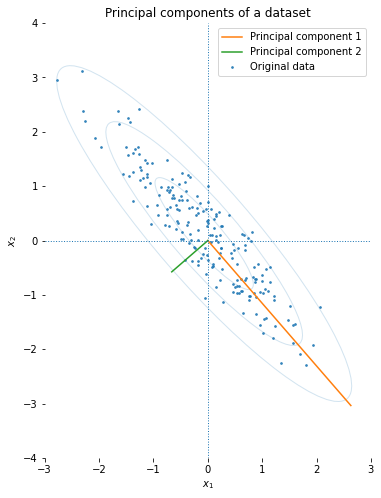

In [5]:
from jhwutils import ellipse as ellipse

# Compute the eigenvalues and eigenvectors of the 2D covariance matrix
evals, evecs = np.linalg.eig(np.cov(x, rowvar=False))

evals_sorted = evals[np.argsort(-np.abs(evals))]
evecs_sorted = evecs[:, np.argsort(-np.abs(evals))]

# Plot the dataset
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x[:, 0], x[:, 1], c='C0', label="Original data", s=3, alpha=0.8)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

# Plot ellipses to show covariance of data
ellipse.cov_ellipse(ax, x[:, 0:2], 1, facecolor='none', edgecolor='C0', alpha=0.2)
ellipse.cov_ellipse(ax, x[:, 0:2], 2, facecolor='none', edgecolor='C0', alpha=0.2)
ellipse.cov_ellipse(ax, x[:, 0:2], 3, facecolor='none', edgecolor='C0', alpha=0.2)

# Plot eigenvectors of covariance matrix * 3 (so they reach the radius of the 3rd ellipse)
def plot_evec(ix):    
    ax.plot([0, evecs_sorted[0, ix] * 3 * np.sqrt(evals_sorted[ix])], 
            [0, evecs_sorted[1, ix] * 3 * np.sqrt(evals_sorted[ix])], color='C'+str(ix+1),             
             label='Principal component {ix}'.format(ix=ix+1))

plot_evec(0)
plot_evec(1)
# fix details
ax.set_xlim(-3, 3)
ax.set_ylim(-4, 4)

ax.axhline(0, lw=1, ls=':')
ax.axvline(0, lw=1, ls=':')
ax.set_aspect(1.0)
ax.legend()
ax.set_frame_on(False)
ax.set_title("Principal components of a dataset");

## Reconstruction of the covariance matrix from its eigenvectors and eigenvalues

Since we are able to decompose the covariance matrix into its constituent eigenvectors and eigenvalues, we must also be able to use these constituent parts to reconstruct the covariance matrix. We can do this as follows:

$$\Sigma = Q\Lambda Q^T$$

where $Q$ is a matrix of unit eigenvectors $\vec{x_i}$ (same as the output `np.linalg.eig`) and $\Lambda$ is a diagonal matrix of eigenvalues ($\lambda_i$ on the diagonal, zero elsewhere).

Let's try it:

In [7]:
reconstructed_A = evecs @ np.diag(evals) @ evecs.T
print_matrix("Q", evecs)
print_matrix("\Lambda", np.diag(evals))

# Display reconstructed covariance matrix for comparison 
# with original covariance matrix (see previous cell)
print_matrix("\Sigma = Q\Lambda Q^T", reconstructed_A)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Hey presto! We've recovered the covariance matrix. 

## Approximating a matrix

Imagine we started with a very high dimensional data set, so $\Sigma$ is a very large matrix. It's so large, we don't want to store it in memory. Instead, we just want to store the first few principal components and use these to reconstruct an *approximation* to $\Sigma$. Providing we keep the largest principal components, we will probably retain most of the information. 

Let's demonstrate this with our 2D covariance matrix. We can approximate the matrix by *truncating* the list of eigenvalues and eigenvectors, i.e. setting the smallest of the eigenvalues and eigenvectors to 0. 

In [8]:
# truncate small eigenvalues to 0
approx_evals = np.where(np.abs(evals)<1e-1, 0, evals)
print_matrix("\hat{\Lambda}", np.diag(approx_evals))

# construct an approximation to A using the truncated eigenvalue matrix
approx_A = evecs @ np.diag(approx_evals) @ evecs.T
print_matrix("\hat{A} = Q \hat{\Lambda}Q", approx_A)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Matrix approximation can be used to simplify transformations or to compress matrices for data transmission.

The eigenspectrum gives us an idea of how simply a matrix could be approximated:
* One large eigenvalue and many small ones - just one vector might approximate this matrix. 
* All eigenvalues similar magnitude? We will not be able to approximate this transform easily.


## Dimensionality reduction

We can also reduce the dimensionality of our original dataset by projecting it onto the few principal components of the covariance matrix that we've kept. We can do this by multiplying the dataset matrix by each component and saving the projected data into a new, lower-dimensional matrix.

Let's use our highly correlated 2D data set as an example. Above, we discarded the smaller of the two eigenvectors, leaving us with a single eigenvalue/eigenvector pair. We can project the original 2D dataset onto the remaining eigenvector to yield a 1D dataset as follows:

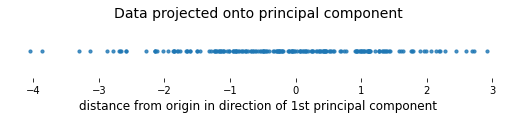

In [9]:
x_projected = x @ evecs[:, 1]

# Plot the dataset
fig = plt.figure(figsize=(9, 1))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x_projected, np.zeros_like(x_projected), c='C0', label="Original data", s=10, alpha=0.8)
ax.set_xlabel('distance from origin in direction of 1st principal component', fontsize=12)
ax.set_yticks(np.arange(0))
ax.set_frame_on(False)
plt.title('Data projected onto principal component', fontsize=14);

In the example above, we reduced a 2D dataset to 1D, but a more common application is the reduction of a high dimensional data set to 2D. If we can reduce a dataset to 2D, we can visualise it by plotting it in a 2D coordinate system. This often reveals structure in the data, such as clusters of data points. We will explore this in this week's lab.

## Uses of eigendecomposition

Matrix decomposition is an *essential* tool in data analysis. It can be extremely powerful and is efficient to implement. Systems such as recommenders (e.g. Netflix, YouTube, Amazon, etc.), search engines (Google), image compression algorithms, machine learning tools and visualisation systems apply these decompositions *extensively*.

Google was wholly built around matrix decomposition algorithms; that's what "PageRank" is. This is what allowed Google to race ahead of their competitors in the early days of the search wars.

The eigendecomposition can be used *anywhere* there is a system modelled as a linear transform (any linear map $\real^N \rightarrow \real^N$). It lets us predict behaviour over different time scales (e.g. very short term or very long term). For instance, we can:

* Find "modes" or "resonances" in a system (e.g physical model of a bridge). 
    * For example, every room has a set of "eigenfrequencies" - the acoustic resonant modes. A linear model of the acoustics of the room could be written as a matrix, and the resonant frequencies extracted directly via the eigendecomposition. [Alvin Lucier's analogue power iterations](https://www.youtube.com/watch?v=fAxHlLK3Oyk)
* Predict the behaviour of feedback control systems: is the autopilot going to be stable or unstable?
* Partition graphs and cluster data (spectral clustering). 
* Predict flows on graphs.
* Perform Principal Component Analysis on high-dimensional data sets for exploratory data analysis, 2D visualisation or data compression.

As soon as we can write down a matrix $A$ we can investigate its properties with the eigendecomposition. *It is the microscope of the linear algebraist.*

---

## Matrix properties from the eigendecomposition

### Trace

The trace of a square matrix can be computed from the sum of its diagonal values:

$$\text{Tr}(A) = a_{1,1} + a_{2,2} + \dots + a_{n,n}$$

It is also equal to the sum of the eigenvalues of $A$

$$\text{Tr}(A) = \sum_{i=1}^n \lambda_i$$

The trace can be thought of as measuring the  **perimeter** of the parallelotope of a unit cube transformed by the matrix. [Strictly, it is *proportional* to the perimeter, with the constant of proportionality being $\text{Perimiter}(A)=2^{n-1} \text{Tr}(A)$].

### Determinant

The determinant $\text{det}(A)$ is an important property of square matrices. It can be thought of as the **volume** of the parallelotope  of a unit cube transformed by the matrix -- it measures how much the space expands or contracts after the linear transform.

It is equal to the product of the eigenvalues of the matrix.

$$\text{det}(A) = \prod_{i=1}^n \lambda_i$$

If any eigenvalue $\lambda_i$ of $A$ is 0, the determinant $\det(A)=0$, and the transformation collapses at least one dimension to be completely flat. This means that the transformation **cannot be reversed**; information has been lost.


### Definite and semi-definite matrices

A matrix is called **positive definite** if all of its eigenvalues are greater than zero: $\lambda_i > 0$. It is **positive semi-definite** if all of its eigenvalues are greater than or equal to zero: $\lambda_i \geq 0$. It is **negative definite** if all of the eigenvalues are less than zero: $\lambda_i < 0$, and **negative semi-definite** if all the eigenvalues are less than or equal to zero: $\lambda_i \leq 0$.

A positive definite matrix $A$ has the property $\vec{x}^TA\vec{x}>0$ for all (nonzero) $\vec{x}$. This tells us that the dot product of $\vec{x}$ with $A \vec{x}$ must be positive (N.B. $A \vec{x}$ is the vector obtained by transforming $\vec{x}$ with $A$). This can only happen if the angle $\theta$ between $\vec{x}$ and $A \vec{x}$ is less than $\frac{\pi}{2}$, since $\vec{x}^TA\vec{x} = |\vec{x}||A \vec{x}|\cos{\theta}$. That means that $A$ does not rotate $\vec{x}$ through more than $90^{\circ}$.

Positive definiteness will be an important concept when we discuss **covariance matrices** (important in statistical data analysis) and **Hessian matrices**  (important in numerical optimisation).


---

# Summary of eigenproblems

* Eigenvectors exist only for square matrices.

* A matrix $A$ transforms a general vector by rotating and scaling it. However, the eigenvectors of $A$ are special because they can only be scaled, not rotated by the transform. 

* The eigenvalues of $A$ are the scaling factors $\lambda_i$ that correspond to each unit eigenvector $\vec{x_i}$.

* Eigenvectors and eigenvalues can be computed algorithmically (e.g. by the power iteration algorithm for finding the **leading eigenvector**).

* Eigendecomposition is the process of breaking a matrix down into its constituent eigenvalues and eigenvectors. These serve as a compact **summary** of the matrix. 

* The **eigenspectrum** is just the list of (absolute) eigenvalues of a matrix, in rank order, largest first. 

* If we have a complete set of eigenvectors and eigenvalues, we can reconstruct the matrix. 

* We can approximate a large matrix $A$ with a few leading eigenvectors; this is a simplified or **truncated** approximation to the original matrix.

* If we repeatedly apply a matrix $A$ to some vector $\vec{x}$, the vector will be stretched more and more along the largest eigenvectors.


## Things we can tell from eigenvectors/values:

* If a matrix has one or more zero eigenvalues, the transform it performs is one that collapses one or more dimensions in vector space. This type of operation is irreversible, and this tells us that $A$ is singular (un-invertible) - more on that in a moment.

* Eigenvectors corresponding to larger (absolute) eigenvalues are more "important"; they are represent directions in which data will get stretched most.

* If the eigenspectrum is nearly flat (eigenvalues all have similar values), then $A$ represents a transform that stretches vectors almost equally in all directions (like transforming a sphere to a sphere).

* If the eigenspectrum has a few large eigenvalues and lots of small ones, then vectors will get stretched along a few directions, but shrink away to nothing along others (like transforming a sphere to a long, skinny ellipse). 

---

---

# Matrix Inversion

We have seen four basic algebraic operations on matrices:

* scalar multiplication $cA$;
* matrix addition $A+B$;
* matrix multiplication $BA$
* matrix transposition $A^T$

There is a further important operation: **inversion** $A^{-1}$, defined such that:

* $A^{-1}(A\vec{x}) = \vec{x}$, 
* $A^{-1}A = I$ 
* $(A^{-1})^{-1} = A$
* $(AB)^{-1} = B^{-1}A^{-1}$

The equivalent of division for matrices is left-multiplication by the inverse. This has the effect reversing or undoing the effect of the original matrix. 

*Inversion is only defined for certain kinds of matrices, as we will see below.*

## Computing the inverse of a matrix

There are many ways to compute the inverse of a matrix. There is a standard recursive algorithm which you may have seen in Maths courses, but this is only useful for very small matrices. Instead, we often use the workhorse of matrix decompositions: the **singular value decomposition**, which we will discuss later.

In the meantime, we can use the NumPy method `np.linalg.inv`, as shown below:

In [10]:
# Create a matrix A of random numbers
A = np.random.normal(0, 1, (3, 3))
print_matrix("A", A)
# Now invert it
print_matrix("A^{-1}", np.linalg.inv(A))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Inversion as "undo"

Inversion of a matrix creates a new linear operator which reverses the original operation. Let's see it in action:

In [11]:
# Verify that left-multiplying by the inverse "undoes"  
# transformation applied by A to a random vector x
# Create a random vector
x = np.random.normal(0, 1, (3, 1))
print_matrix("x", x)
# Tranform it
print_matrix("Ax", A @ x)
# Left-multiply by inverse to recover the original vector
print_matrix("A^{-1}(Ax)", np.linalg.inv(A) @ (A @ x))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Inversion creates a matrix that "undoes" the transformation performed by another matrix, so long as no information was lost in the transformation. We can illustrate this geometrically:

<IPython.core.display.Latex object>

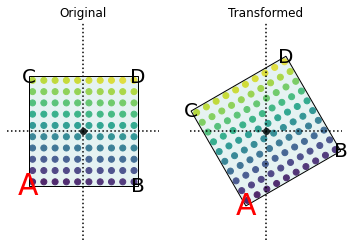

In [14]:
# Create a matrix that performs a 30 degree rotation
d30 = np.radians(30)
cs = np.cos(d30)
ss = np.sin(d30)
rot_mat = np.array([[cs, -ss], [ss, cs]])
# Display the effect of this matrix
show_matrix_effect(rot_mat)

<IPython.core.display.Latex object>

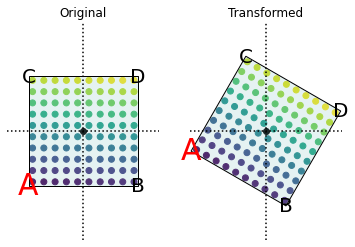

In [15]:
# Compute the inverse of the 30 degree rotation matrix
show_matrix_effect(np.linalg.inv(rot_mat))

<IPython.core.display.Latex object>

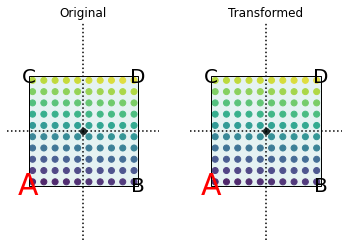

In [16]:
# Show the combined effect of the 30 degree rotation matrix, 
# left-multiplied by its inverse
show_matrix_effect(np.linalg.inv(rot_mat) @ rot_mat)

## Only square matrices can be inverted

Inversion is only defined for square matrices, representing a linear transform $\real^n \rightarrow \real^n$. This is equivalent to saying that the determinant of the matrix must be non-zero: $\det(A) \neq 0$. Why?

A matrix which is non-square maps vectors of dimension $m$ to dimension $n$. This means the transformation collapses or creates dimensions. Such a transformation is not uniquely reversible.

For a matrix to be invertible it must represent a **bijection** (a function that maps every member of a set onto exactly one member of another set).

## Singular and non-singular matrices

A matrix with $\det(A)=0$ is called **singular** and has no inverse.

A matrix which is invertible is called **non-singular**. 

The geometric intuition for this is simple. Going back to the paralleogram model, a matrix with zero determinant has at least one zero eigenvalue. This means that at least one of the dimensions of the parallelepiped has been squashed to nothing at all. Therefore it is impossible to reverse the transformation, because information was lost in the forward transform. 

All of the original dimensions must be preserved in a linear map for inversion to be meaningful; this is the same as saying $\det(A) \neq 0$.

<img src="imgs/inversion.png">

<IPython.core.display.Latex object>

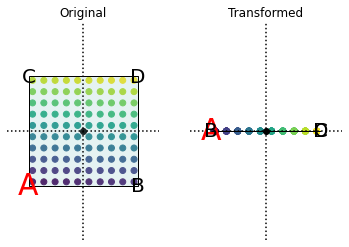

In [17]:
# The following matrix is singular
sing_mat = np.array([[0.0, 1], 
                    [0, 0.0]])
# Display its effect
show_matrix_effect(sing_mat)

In [18]:
# Attempting to invert a singular matrix throws an error
try:
    show_matrix_effect(np.linalg.inv(sing_mat))
except:
    print("LinAlgError: Singular matrix")

LinAlgError: Singular matrix


## Numerical stability of matrix inversion algorithms

Because matrix operations involve *lots* of repeated floating point operations there are many opportunities for roundoff to accumulate. There is a great deal of importance in finding matrix algorithms which are **numerically stable**; that is they converge to the right answer reliably. 

Inversion is particularly hard to compute in a stable form directly, and many matrices that *theoretically* could be inverted cannot be inverted using floating point representation. 

### Special cases

Just as for multiplication, there are many special kinds of matrices for which much faster inversion is possible. These include, among many others:

* orthogonal matrix (rows and columns are all orthogonal unit vectors): $O(1)$, $A^{-1}= A^T$
* diagonal matrix (all non-diagonal elements are zero): $O(n)$, $A^{-1} = \frac{1}{A}$ (i.e. the reciprocal of the diagonal elements of $A$).
* positive-definite matrix: $O(n^2)$ via the *Cholesky decomposition*. We won't discuss this further.
* triangular matrix (all elements either above or below the main diagonal are zero): $O(n^2)$, trivially invertible by **elimination algorithms**.

#### Special cases: orthogonal matrices

An **orthogonal matrix** is a special matrix form that has $A^T=A^{-1}$; that is the transpose and the inverse are equivalent. All of its component eigenvectors are **orthogonal** to each other (at 90 degrees; have an inner product of 0), and all of its eigenvalues are 1 or -1. An orthogonal matrix transforms a cube to a cube. It has a determinant of 1 or -1. Any purely rotational matrix is an orthogonal matrix. 

Orthogonal matrices can be inverted trivially, since transposition is essentially free in computational terms.

In [ ]:
# Create an orthogonal matrix and show its effect
A = np.array([[0, 1, 0], 
              [-1, 0, 0], 
              [0, 0, 1]])
show_matrix_effect(A, "A")

In [ ]:
# Show the effect of its transpose and show that the inverse is the same as the transpose
show_matrix_effect(A.T, "A^T")
print_matrix("A^{-1}", np.linalg.inv(A))

#### Special cases: Diagonal matrices

The inverse of a diagonal matrix is another diagonal matrix whose diagonal elements are the reciprocal of each of the diagonal elements of the original matrix:

$$A^{-1}_{ii} = \frac{1}{A_{ii}}$$

This is $O(n)$ to compute, so much faster than standard inversion.

In [ ]:
# Create a diagonal matrix
d = np.diag([-1, 2, -3, 4])
print_matrix('D', d)
# Compute the reciprocal, elementwise
print_matrix('\\frac{1}{D}', np.diag(1/np.diag(d)))
# Comput the inverse
print_matrix('D^{-1}', np.linalg.inv(d))

### Issue with inversion of sparse matrices

The inverse of a **sparse matrix** is in general **not sparse**; it will (most likely) be dense. This means that sparse matrix algorithms virtually never involve a direct inverse, as a sparse matrix could easily be 1,000,000 x 1,000,000, but with maybe only a few million non-zero entries, and might be stored in a few dozen megabytes. The inverse form would have 1,000,000,000,000 entries and require a terabyte or more to store!

## Solving problems with inversion

Revisiting the problem of package distribution, we can use inversion to solve the problem of predicting the distribution at $\vec{x_{t=-1}}$ given $\vec{x_{t=0}}$. Applying $A$ to $\vec{x}$ took us "one step" into the future. Applying $A^{-1}$ takes us one step into the past:

$$\vec{x_{t=-1}} = A^{-1} \vec{x_{t=0}}$$

We can compute any negative power of the matrix to "undo" any number of steps:

$$A^{-k} = \underbrace{A^{-1}A^{-1}A^{-1}\dots A^{-1}}_{\text{k repetitions}}$$


However, be aware that inversion is highly problematic from a numerical point of view, and roundoff error will lead to severely distorted results with repeated negative powers of a matrix.

## Linear systems

One way of looking at matrices is as a collection of weights of components of a vector. Consider:

$$A = \begin{bmatrix}
0.5 & 1.0 & 2.0\\
1.0 & 0.5 & 0.0\\
0.6 & 1.1 & -0.3\\
\end{bmatrix}$$    

This represents a linear map operating on 3D vectors $\vec{x}\in\real^3$. It produces a 3D vectors $\vec{y}\in\real^3$, each component of which is a **weighted sum** of the components of the input vector.

$$y_1 = 0.5x_1 + 1.0x_2 +2.0x_3\\
y_2 = 1.0x_1 +0.5x_2 +0.0x_3\\
y_3 = 0.6x_1 + 1.1x_2 - 0.3x_3$$

The coefficients of the matrix represent the weighting to be applied.

In [19]:
A = np.array([[0.5, 1.0, 2.0], 
              [1.0, 0.5, 0.0],
              [0.6, 1.1, -0.3]])

x = np.array([[1], [-1], [1]])

print_matrix("A", A)
print_matrix("\\bf x", x)
print_matrix("y=A{\\bf x}", A @ x)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


This is exactly what happens in the package distribution example; the matrix represents the equations that define the flow between depots. You could interpret one row as follows:

$$\begin{bmatrix} 0.9 & 0.0 & 0.0 & 0.2 & 0.0 & 0.05 & 0.08 & 0.0 \end{bmatrix}$$

> Tomorrow, Depot A will have 90% of Depot A's stock, 20% of Depot D's stock, 5% of Depot F's stock and 8% of Depot G's stock.

$$ y_1 = 0.9x_1 + 0.2x_4 + 0.05x_6 + 0.08x_7 $$

This is the form that simultaneous equations take. If we know $A$ and $\vec{y}$, we can ask what $\vec{x}$ will satisfy the following equation (or if there even exists an $\vec{x}$ that would satisfy it):

$$ A\vec{x} = \vec{y}$$

This is a **linear system** or **linear system of equations**. 

## Solving linear systems

The solution of linear systems is apparently simple for cases where $A$ is square. If $A\vec{x}=\vec{y}$, then left-multiplying both sides by $A^{-1}$ we get 

$$
A^{-1}A\vec{x}=A^{-1}\vec{y}\\
I \vec{x} = A^{-1} \vec{y}\\
\vec{x} = A^{-1}\vec{y}
$$

This only works for square matrices, as $A^{-1}$ is not defined for non-square matrices. This means that $\vec{x}$ and $\vec{y}$ must have the same number of dimensions.

In [ ]:
# try for a different y and find what x is
y = np.array([[10], [1], [12]])
A_inv = np.linalg.inv(A)
x_solved = A_inv @ y
print_matrix("A", A)
print_matrix("{\\bf y}", y)
# find the correct x
print_matrix("{\\bf x}=A^{-1}{\\bf y}", x_solved)
# verify that we have solved these equations by checking that Ax = y
print_matrix("A{\\bf x}", A @ x_solved)

## Approximate solutions for linear systems

In practice, linear systems are almost never solved with a direct inversion. The numerical problems in inverting high dimensional matrices will make the result highly unstable, and tiny variations in $\vec{y}$ might lead to wildly different solutions for $\vec{x}$.

Instead, linear systems are typically solved iteratively, either using specialised algorithms based on knowledge of the structure of the system, or using **optimisation**, which will be the topic of the next Unit.

These algorithms search the possible space of $\vec{x}$ to find solutions that minimise
$\|A\vec{x}-\vec{y}\|_2^2$ by adjusting the value of $\vec{x}$ repeatedly.

The reason these iterative approximation algorithms can work when inversion is numerically impossible is that they only have to solve for one *specific* pair of vectors $\vec{x}, \vec{y}$. They do not have to create an inversion $A^{-1}$ that inverts the problem for all possible values of $\vec{y}$, just the specific $\vec{y}$ seen in the problem. This problem is much more constrained and therefore much more stable.

---

---

# Singular value decomposition

Eigendecompositions only apply to diagonalizable matrices; which are a subset of square matrices. But the ability to "factorise" matrices in the way the eigendecomposition does is enormously powerful, and there are many problems which have non-square matrices which we would like to be able to decompose.

The **singular value decomposition** (SVD) is a general approach to decomposing any matrix $A$. It is the powerhouse of computational linear algebra.

The SVD produces a decomposition which splits ***ANY*** matrix up into three matrices:

$$A=U\Sigma V^T,$$

where 
* $A$ is any $m \times n$ matrix, 
* $U$ is a **square unitary** $m \times m$ matrix, whose columns contain the **left singular vectors**,
* $V$ is an **square unitary** $n \times n$ matrix, whose columns contain the **right singular vectors**,
* $\Sigma$ is a diagonal $m \times n$ matrix, whose diagonal contains the **singular values**.

A **unitary** matrix is one whose conjugate transpose is equal to its inverse. If $A$ is real, then $U$ and $V$ will be **orthogonal** matrices ($U^T = U^{-1}$), whose rows all have unit norm and whose columns also all have unit norm.

The diagonal of the matrix $\Sigma$ is the set of **singular values**, which are closely related to the eigenvalues, but are *not* quite the same thing (except for special cases like when $A$ is a positive semi-definite symmetric matrix)! The **singular values** are always positive real numbers.

We can compute the SVD with `np.linalg.svd`:

In [20]:
def print_svd(A):
    
    # Print A
    print_matrix("A", A)
    
    # Take SVD
    u, sigma, vt = np.linalg.svd(A)
    
    # Print U, then norms of rows and norms of columns in U
    print_matrix("U", u)
    print_matrix("\|U\|_{rows}", np.linalg.norm(u, axis=1))
    print_matrix("\|U\|_{cols}", np.linalg.norm(u, axis=0))
    
    # By default, sigma will be a vector of the diagonal values
    # np.diag(sigma) converts the vector back to a diagonal matrix
    sigma_diag = np.zeros_like(A)
    sqr = min(A.shape[0], A.shape[1])
    sigma_diag[:sqr, :sqr] = np.diag(sigma)
    
    # Print sigma (as a diagonal matrix)
    print_matrix("\Sigma", sigma_diag)
    
    # Print V, then norms of rows and norms of columns in V
    print_matrix("V", vt.T)
    print_matrix("\|V\|_{rows}", np.linalg.norm(vt.T, axis=1))
    print_matrix("\|V\|_{cols}", np.linalg.norm(vt.T, axis=0))
    
    def recompose(u, sigma, vt):
        return u @ sigma @ vt
    
    # Print recomposed version of A (A = U Sigma V)
    print_matrix("U \Sigma V^T", recompose(u, sigma_diag, vt))

In [29]:
# Create a square matrix A
A = np.array([[0.5, 2, 3],
              [4,   5, 6],
              [7,   8, 9]])
# Take the SVD and print all the decomposed parts
print_svd(A)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [23]:
# Create a non-square 2 x 3 matrix A
A = np.array([[0.1, 0.2, 0.3],
              [0.4, 0.5, 0.6]])
# Take the SVD and print all the decomposed parts
print_svd(A)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [24]:
# Create a non-square 3 x 2 matrix A
A = np.array([[0.1, 0.2, 0.3],
              [0.4, 0.5, 0.6]]).T
# Take the SVD and print all the decomposed parts
print_svd(A)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Relation to eigendecomposition
The SVD is the same as:
* taking the eigenvectors of $A^TA$ to get $U$
* taking the square root of the *absolute* value of the eigenvalues $\lambda_i$ of $A^TA$ to get $\Sigma_i = \sqrt{|\lambda_i|}$
* taking the eigenvectors of $AA^T$ to get $V^T$

In [25]:
# Create a 3 x 2 matrix A
A = np.array([[0.1, 0.2, 0.3],
              [0.4, 0.5, 0.6]]).T

print_matrix('A', A)

# Compute eigenvalues and eigenvectors of the matrices A A^T and A^T A
l_evals, l_evecs = np.linalg.eig(A @ A.T)
r_evals, r_evecs = np.linalg.eig(A.T @ A)

# compare eigenvector matrices to U and V from SVD
u, sigma, vt = np.linalg.svd(A)
print_matrix("\\text{eigenvectors of}\ AA^T", l_evecs)
print_matrix("U", u)

print_matrix("\\text{eigenvectors of}\ A^TA", np.fliplr(r_evecs)) # flip for comparison with V
print_matrix("V^T", vt)

# compare eigenvalues to Sigma
print_matrix("\sqrt{|\lambda|} \; \\text{of} \; AA^T", np.sqrt(np.abs(l_evals)))
print_matrix("\sqrt{|\lambda|} \; \\text{of} \; A^TA", np.sqrt(np.abs(r_evals))[::-1]) # flip for comparison with Sigma
print_matrix("\Sigma", sigma)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Special case: symmetric, positive semi-definite matrix

For a symmetric, positive semi-definite matrix $A$, the eigenvectors are the columns of $U$ or the columns of $V$. The eigenvalues are in $\Sigma$.

In [26]:
# create a symmetric positive semi-definite 3 x 3 matrix
A = np.array([[2, 1, 0],
              [1, 3, 1],
              [0, 1, 4]])
print_matrix("A", A)

# Find eigenvectors and eigenvalues
evals, evecs = np.linalg.eig(A)
print_matrix("\lambda", evals[::-1])       # Reverse order of eigenvalues to get them in size order
print_matrix("\\bf{x}", np.fliplr(evecs))  # Flip eigenvector matrix left right to correspond with ordered eigenvalues

# Take the SVD
u, sigma, vt = np.linalg.svd(A)
print_matrix("\Sigma", sigma)
print_matrix("U", u)
print_matrix("V", vt.T)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## SVD decomposes *any* matrix into three matrices with special forms

Special forms of matrices, like orthogonal matrices and diagonal matrices, are much easier to work with than general matrices. This is the power of the SVD.

* $U$ is orthogonal, so is a pure rotation matrix,
* $\Sigma$ is diagonal, so is a pure scaling matrix, 
* $V$ is orthogonal, so is a pure rotation matrix.

#### Rotate, scale, rotate

*The SVD splits any matrix transformation into a rotate-scale-rotate operation.*

<IPython.core.display.Latex object>

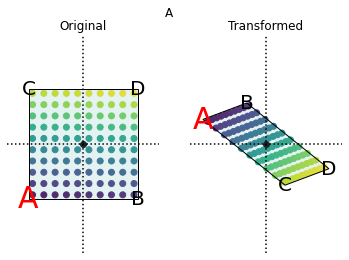

In [27]:
# Create a matrix A that performs a rotation and scaling transformation
A = np.array([[0.4, 0.75], 
              [0.15, -0.6]])

show_matrix_effect(A, "A")

Let's break this transformation down into its consitutent parts: 

* $V^T$: rotation,
* $\Sigma$: scaling,
* $U$: rotation.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

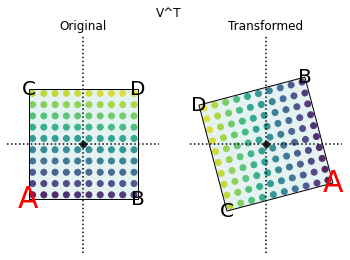

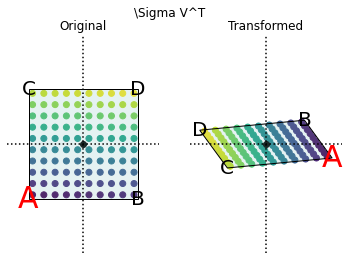

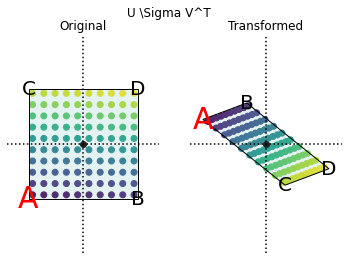

In [28]:
u, sigma, vt = np.linalg.svd(A)

show_matrix_effect(vt, "V^T")
show_matrix_effect(np.diag(sigma) @ vt, "\Sigma V^T")
show_matrix_effect(u @ np.diag(sigma) @ vt, "U \Sigma V^T")

## Using the SVD

Many matrix operations are trivial once we have the factorisation of the matrix into the three components. But some can only be performed on *on certain types of matrices*.

###  Fractional powers

We can use the SVD to compute interesting matrix functions like the square root of a matrix $A^{1/2}$. In fact, we can use the SVD to raise a matrix to any power, *in a single operation*, provided it is a **square symmetric matrix**. 

We can use the SVD to:

* raise a matrix to a fractional power, e.g. $A^{1/2}$, which will "part do" an operation,
* invert a matrix: $A^{-1}$, which will "undo" the operation.

The rule is simple: to do any of these operations, ignore $U$ and $V$ (which are just rotations), and apply the function to the singular values elementwise:

$$ A^n = V \Sigma^n U^T $$

For a symmetric matrix, this is the same as:

$$ A^n = U \Sigma^n V^T $$

**Note: $A^{1/2}$ is not the elementwise square root of each element of A!** 

Rather, we must comput the elementwise square root of $\Sigma$, then compute $A^{1/2} = U \Sigma^{1/2} V^T$.

In [ ]:
def powm(A, n): # generalised matrix power
    u, sigma, vt = np.linalg.svd(A)
    sigma_n = np.diag(sigma**n)
    return u @ sigma_n @ vt
    #return vt.T @ sigma_n @ u.T  # gives the same result as (u @ sigma_n @ vt) for a symmetric matrix

In [ ]:
# Create a square, symmetric matrix
A = np.array([[0.5, -1], 
              [-1, 3]])

print_matrix("A", A)

# Compute A^(1/2)
a_half = powm(A, 0.5)
print_matrix("A^{1/2}", a_half)

# A^(1/2) A^(1/2) should be equal to A
print_matrix("A^{1/2} A^{1/2}", a_half @ a_half)

# Compute A^2
print_matrix("A^2", powm(np.array(A), 2))

# AA should be equal to A^2
print_matrix("AA", A @ A)

### Inversion

We can efficiently invert a matrix once it is in SVD form. For a non-symmetric matrix, we use:

$$A ^{-1} = V \Sigma^{-1} U^T.$$

This can be computed in $O(n)$ time because $\Sigma^{-1}$ can be computed simply by taking the reciprocal of each of the diagonal elements of $\Sigma$. 

*N.B. As a consequence, we now know that computing the SVD must take $O(n^3)$ time for square matrices, since inversion cannot be achieved faster than $O(n^3)$.*

In [ ]:
# Inversion using the SVD
def invert_by_svd(u, sigma, vt):
    sigma_inv = np.zeros((u.shape[0], vt.shape[0]))
    sqr = min(vt.shape[0], u.shape[0])
    sigma_inv[:sqr, :sqr] = np.diag(1.0/sigma)    
    return vt.T @ sigma_inv @ u.T

# Create a non-symmetric, square matrix that we want to invert
A = np.array([[1,  2, 3], 
              [4, -5, 6], 
              [7, -8, 9.5]])

# Take the SVD
u, sigma, vt = np.linalg.svd(A)

print_matrix("A", A)

# Comput the inverse of A using two different methods, and compare
print_matrix("V \Sigma^{-1} U^T", invert_by_svd(u, sigma, vt))
print_matrix("A^{-1}", np.linalg.inv(A))

### Pseudo-inverse

We can also pseudo-invert a matrix: $A^{+}$, which will approximately "undo" the operation, even when $A$ isn't square.

This means we can solve (approximately) systems of equations where the number of input variables is different to the number of output variables. The **pseudo-inverse** or **Moore-Penrose pseudo-inverse** generalises inversion to (some) non-square matrices. 

We can find approximate solutions for $\vec{x}$ in the equation:

$$A\vec{x} = \vec{y},$$ 

or in fact simultaneous equations of the type

$$AX = Y$$ 

The pseudo-inverse of $A$ is just 

$$A^{+} = V \Sigma^{-1} U^T,$$ 

which is the same as the standard inverse computed via SVD, but taking care that $\Sigma$ is the right shape - appropriate zero padding is required! Fortunately, this is taken care of by the Numpy method `np.linalg.pinv`.

In [ ]:
# Create a non-square matrix, so that we can find the pseudo-inverse
A = np.array([[0.5, 1.0, 2.0], 
              [1.0, 0.5, 0.0]])

print_matrix("A", A)

# Create a vector y
y = np.array([[2], [5]])

print_matrix("\\bf{y}", y)

# We want to know what x is, so we have to invert A using the pseudo-inverse
A_pinv = np.linalg.pinv(A) # pseudo-inverse is called pinv in NumPy

print_matrix("A^{+}", A_pinv)

# Compute x
x = A_pinv @ y

print_matrix("\\bf{x} = A^{+} \\bf{y}", x)

# check that Ax = y
print_matrix("A \\bf{x}", A @ x)

If the problem does not have an exact solution, the pseudo-inverse will give the closest result according to the $L_2$ norm. In other words, it will find the vector $\vec{x}$ that minimises the distance $\|A\vec{x} - \vec{y}\|_2$:

In [ ]:
# Create a non-square matrix, so that we can find the pseudo-inverse
A = np.array([[0.5, 1.0, 2.0], 
              [1.0, 0.5, 0.0]]).T

print_matrix("A", A)

# Create a vector y
y = np.array([[1], [2], [3]])

print_matrix("\\bf{y}", y)

# We want to know what x is, so we have to invert A using the pseudo-inverse
A_pinv = np.linalg.pinv(A) 

print_matrix("A^{+}", A_pinv)

# Compute x
x = A_pinv @ y

print_matrix("\\bf{x} = A^{+} \\bf{y}", x)

# check that Ax = y
# won't be exact, as there are no exact solutions
print_matrix("A \\bf{x}", A @ x)

## Fitting lines/planes using the pseudo-inverse

Suppose we have a data set which consists of multiple examples of $\vec{x}$ and $\vec{y}$, stored in data matrices $X$ and $Y$, where each example forms a row. We'd like to fit a line/plane to this data such that we can predict an individual $y$-value using the formula $\vec{y} = A \vec{x}$, or lots of $y$-values using the formula $Y = AX$. The equation for the line/plane is represented by the matrix $A$, and this is what we want to find.

We can find an approximate solution for $A$ by using the pseudo-inverse on our existing data set:

$$A = X^+Y$$

This allows us to fit a line/plane to a collection of data points, even when we have many more points than the number of dimensions required to specify the line/plane (standard inversion would require us to have exactly the same number of data points as dimensions, in order to obtain an exact solution). A system of equations where there are more inputs than outputs is called "overdetermined". The pseuo-inverse allows us to solve overdetermined problems like this one.

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np

# Create a set of 300 random data points x, where each data point has two features
n = 300
d = 3
x = np.random.uniform(-1, 1, (n, d-1))

# create a matrix representing a linear function of x, i.e. a plane, which we'll use to simulate the y data
A_plane = np.array([[4], [8]])

# calculate the data points y that correspond to those in x
y = x @ A_plane

# add some noise to simulate real data
y += np.random.normal(0, 1.0, y.shape)

# plot the data
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x[:,0], x[:,1], y)

# compute a matrix that represents the plane of best fit to the data: A = (X^+ Y)
plane = np.linalg.pinv(x) @ y

# plot the fitted plane
space = np.linspace(-1, 1, 100)
mx, my = np.meshgrid(space, space)
ax.plot_wireframe(mx, my, mx*plane[0] + my*plane[1], alpha=0.1, color='C1');

---

## Rank of a matrix

The **rank** of a matrix is equal to the number of non-zero singular values. 

* If the number of non-zero singular values is equal to the size of the matrix, then the matrix is **full rank**. 
* A full rank matrix has a non-zero determinant and will be invertible. 
* The rank tells us how many dimensions the parallelotope that the transform represents will have. 
* If a matrix does not have full rank, it is **singular** (non-invertible) and has **deficient rank**.
* If the number of non-zero singular values is much less than the size of the matrix, the matrix is **low rank**.

For example, a 4 x 4 matrix with rank 2 will take vectors in $\real^4$ and output vectors in a $\real^2$ subspace (a plane) of $\real^4$. The orientation of that plane will be given by the first two eigenvectors of the matrix.

## Condition number of a matrix

The **condition number** number of a matrix is the ratio of the largest singular value to the smallest. 

* This is only defined for full rank matrices. 
* The condition number measures how sensitive inversion of the matrix is to small changes.
* A matrix with a small condition number is called **well-conditioned** and is unlikely to cause numerical issues. 
* A matrix with a large condition number is **ill-conditioned**, and numerical issues are likely to be significant. 

An ill-conditioned matrix is almost singular, so inverting it will lead to invalid results dur to floating point roundoff errors.

### Relation to singularity

A **singular** matrix $A$ is un-invertible and has $\det(A)=0$. Singularity is a binary property, and is either true or false. 

**Rank** and **condition numbers** extend this concept.

<img src="imgs/matrix_spectrum.png">

* We can think of **rank** as measuring "how singular" the matrix is, i.e. how many dimensions are lost in the transform.
* We can think of the **condition number** as measuring how close a non-singular matrix is to being singular. A matrix which is nearly singular may become effectively singular due to floating point roundoff errors.

In [ ]:
print("Well-conditioned matrix")
well_cond = np.random.normal(0, 1, (3, 3))
print("Condition number:", np.linalg.cond(well_cond))
print_matrix("A", well_cond)

In [ ]:
# verify that condition number is ratio of largest to smallest singular values
u, sigma, vt = np.linalg.svd(well_cond)
print(sigma)
print("Ratio of max to min singular values:", np.max(sigma)/np.min(sigma))

In [ ]:
# check that, for a well-conditioned matrix, if we apply the matrix twice, 
# followed by the inverse twice, this results in the identity matrix I
print_matrix("A^{-1}A^{-1}AA", np.linalg.inv(well_cond) @ np.linalg.inv(well_cond) @ well_cond @ well_cond)

In [ ]:
print("Ill-conditioned matrix")
ill_cond = np.random.normal(2000000, 0.002, (3, 3))
print("Condition number:", np.linalg.cond(ill_cond))
print_matrix("A", ill_cond)

In [ ]:
u, sigma, vt = np.linalg.svd(ill_cond)
print(sigma)
print("Ratio of max to min singular values:", np.max(sigma)/np.min(sigma))

In [ ]:
# for an ill-conditioned matrix, if we apply the matrix twice, 
# followed by the inverse twice, we don't get the identity matrix I,
# due to floating point error accumulation
print_matrix("A^{-1}A^{-1}AA", np.linalg.inv(ill_cond) @ np.linalg.inv(ill_cond) @ ill_cond @ ill_cond)

In [ ]:
# this matrix is rank 2 and projects 3D space onto a plane
A = np.array([[1,  2,  3], 
              [2,  4,  6], 
              [0, -1, -5]])

u, sigma, vt = np.linalg.svd(A)

# one of the singular values is zero
print_matrix("\Sigma", sigma)

---

# Applying decompositions

## Whitening a data set

**Whitening** removes all linear correlations within a dataset. It is a *normalizing* step used to standardise data before analysis. This will be covered in the lab.

Given a data set stored in matrix $X$, we can compute:

$$X^{\text w} = (X - \vec{\mu}) \Sigma^{-1/2}$$

where $\vec{\mu}$ is the **mean vector**, i.e. a row vector containing the mean of each column in $X$, and $\Sigma$ is the **covariance matrix** (not the matrix of singular values).

This equation takes each column of $X$ and subtracts the mean of that column from every element in the column, so that each column is centred on zero. Then it multiplies by the inverse square root of the covariance matrix, which is a bit like dividing each column of $X$ by its standard deviation to normalise the spread of values in each column. However, it is more rigorous than that, because it also removes any correlations between the columns.

To summarise, whitening does the following:

* centers the data around its mean, so it has **zero mean**.
* "squashes" the data so that its distribution is spherical and has **unit covariance**.

Removing the mean is easy. The difficult bit is computing the inverse square root of the covariance matrix. N.B. this is *definitely not* the inverse square root of the elements of the covariance matrix!

Fortunately, we can compute it easily by taking the SVD of the covariance matrix. We compute the inverse square root in one step, by taking the reciprocal of the square root of each of the singular values and then reconstructing. 

The whitened version of the data set will have all linear correlations removed. This is an important preprocessing step when applying machine learning and statistical analysis algorithms. 

In [ ]:
from jhwutils import ellipse as ellipse

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)

# generate a random data set with some correlations
x = np.random.normal(0, 1, (200, 2)) @ np.array([[0.1, 0.5], [-0.9, 1.0]]) + np.array([2, 3])

# plot the data set with some ellipses to indicate the covariance
ax.scatter(x[:, 0], x[:, 1], c='C0', label="Original", s=10)
ellipse.cov_ellipse(ax, x[:, 0:2], 1, facecolor='none', edgecolor='C0')
ellipse.cov_ellipse(ax, x[:, 0:2], 2, facecolor='none', edgecolor='C0')
ellipse.cov_ellipse(ax, x[:, 0:2], 3, facecolor='none', edgecolor='C0')

###################

# center around the mean
center_x = x - np.mean(x, axis=0)

# remove covariance via the SVD
u, sigma, vt = np.linalg.svd(np.cov(center_x, rowvar=False))
# here's the magic trick:
sigma_inv_sqr = vt.T @ np.diag(1.0 / np.sqrt(sigma)) @ u.T
white_x = center_x @ sigma_inv_sqr

####################

# plot the whitened data with some ellipses to indicate the covariance
ax.scatter(white_x[:, 0], white_x[:, 1], c='C1', label="Whitened", s=10)
ellipse.cov_ellipse(
    ax, white_x[:, 0:2], 1, facecolor='none', edgecolor='C1')
ellipse.cov_ellipse(
    ax, white_x[:, 0:2], 2, facecolor='none', edgecolor='C1')
ellipse.cov_ellipse(
    ax, white_x[:, 0:2], 3, facecolor='none', edgecolor='C1')

# fix details
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 8)

ax.axhline(1, ls=':', alpha=0.5)
ax.axvline(1, ls=':', alpha=0.5)
ax.axhline(-1, ls=':', alpha=0.5)
ax.axvline(-1, ls=':', alpha=0.5)

ax.axhline(0)
ax.axvline(0)
ax.set_aspect(1.0)
ax.legend()
ax.set_frame_on(False)
ax.set_title("Whitening a dataset");

---

## Resources
* [**Matrix decompositions**](http://nicolas-hug.com/blog/matrix_facto_1) [**Recommended**]

* [**Eigenvectors and eigenvalues**](http://setosa.io/ev/eigenvectors-and-eigenvalues/)

* [**The Singular Value Decomposition**](http://theory.stanford.edu/~tim/s15/l/l9.pdf)
* [**A tutorial on principal components analysis**](https://arxiv.org/pdf/1404.1100.pdf)

* [**A tutorial on the singular value decomposition**](https://blog.statsbot.co/singular-value-decomposition-tutorial-52c695315254)
### Beyond the course

* [**A tutorial on spectral graph theory and graph Laplacians**](https://csustan.csustan.edu/~tom/Clustering/GraphLaplacian-tutorial.pdf)

* [**Introduction to Linear Algebra**](http://math.mit.edu/~gs/linearalgebra/) by Gilbert Strang. The standard reference text book for linear algebra.
 